# GnomAD_df class use example
After each cell There is an explanation of what it is doing

In [12]:
import numpy as np
import pandas as pd
class GnomAD_df:
        
        
    
    def __init__(self,path, peak_file=None, remove_unkown=True, remove_phased_gt=True, only_peak_variants=True):
        """
        This class warps the result of gnomAD and interval  mATAC/hATAC analysis.
        path - path to the parquet dataframe file 
        peak_file - bed file which contains the following columns - CHROM,FROM,TO,INTERVAL_ID, ~BUT w/o header~
        remove_unknown - removed unkwon genotypes (e.g "./.")' 
        remove_phased_gt - "replaced phased genotype (e.g "0|1" -> "0/1")"
        only_peak_variants - removing variants outside of peak interval
        
        """
        self.__original_df = self.__open_table(path)
        self.f_phasing = False
        self.__filter_samples = []
        self.__filters_description = []
        self.__filter_functions = []
        self.__cur_df = self.__original_df.copy()
        self.__applied_filter_index = 0
        if only_peak_variants:
            self.remove_non_peak_variants()
        if remove_unkown:
            self.remove_unkown()
        if remove_phased_gt:
            self.remove_phasing()
        self.__samples = [i.split(':')[0] for i in self.__original_df.columns if i.endswith('GT')]
        if peak_file != None:
            self.__peak_df = self.__get_peak_df(peak_file)
    
    
    def __get_peak_df(self, path):
        peak_df = pd.read_csv(path, sep='\t', header=None)
        peak_df.columns = ['CHROM', 'FROM','TO', 'INTERVAL_ID']
        return peak_df
    
    def load_peak_file(peak_file_path):
        """
        loads a peak file into the object
        """
        self.__peak_df = self.__get_peak_df(peak_file)
    
    def get_peak_df(self):
        """
        returns the intervals dataframe 
        """
        return self.__peak_df
    
    def __open_table(self, path):
        df = pd.read_parquet(path).fillna(value=np.nan).replace('0/0',np.nan).replace('0|0',np.nan).drop(columns='AF')
        interval = df.INTERVAL_ID.copy()
        df = df.drop(columns='INTERVAL_ID')
        df.insert(0,'INTERVAL_ID',interval)
        return df
    
    
    def add_data(self,str: path,original=True,header=True, sep='\t', list: columns=None):
        """
        add the dataframe from the file / columns which were provided in a list (columns) (If none - all columns will be added)
        the file need to have CHROM,POS, REF,ALT
        if original = True, adds the data to the original otherwise to the current df
        """
        to_add = pd.read_csv(path, sep=sep, header=True).set_index(['CHROM','POS', 'REF','ALT'])
        if not original:
        add_to = self.__original_df.copy() if original  else self.self.__cur_df
        # todo - understand how to integraye the new data- should i uuse reset table.

        
    def __remove_non_peak_variants(self):

        self.__cur_df = self.__cur_df.replace('.', np.nan)
        self.__cur_df = self.__cur_df[~self.__cur_df.INTERVAL_ID.isna()]

    def remove_non_peak_variants(self):
        """
        remove variants if they are not in a peak
        """
        decs="removing variants outside of peak interval"
        
        if self.__check_if_filter_exists(decs):
            self.__filters_description.append("removing variants outside of peak interval")
            self.__filter_functions.append(self.__remove_non_peak_variants)
        return self

    def __remove_unknow(self):
        self.__cur_df = self.__cur_df.replace('./.', np.nan).replace('.|.', np.nan)

    def remove_unkown(self):
        """
        removed unkwon genotypes (e.g "./.")
        """
        decs='removed unkwon genotypes (e.g \"./.\")'
        
        if self.__check_if_filter_exists(decs):
            self.__filters_description.append('removed unkwon genotypes (e.g \"./.\")')
            self.__filter_functions.append(self.__remove_unknow)
        return self

    def remove_phasing(self):
        """
        "replaced phased genotype (e.g "0|1" -> "0/1")"
        """
        desc = "replaced phased genotype (e.g \"0|1\" -> \"0/1\")"
        if self.__check_if_filter_exists(desc):
            self.__filters_description.append(desc)
            self.__filter_functions.append(self.__remove_phasing)
        return self

    def __remove_phasing(self):

        """
        replace all "X|X" into "X/X"
        """
        if self.f_phasing: return
        for col in [i for i in self.__cur_df.columns if i.endswith('GT')]:
            for val in self.__cur_df[col].unique():
                if val == np.nan: continue
                if '|' in str(val):
                    self.__cur_df = self.__cur_df.replace(val, "%s/%s" % tuple(val.split('|')))
        self.f_phasing = True
    
    
    def __check_if_filter_exists(self,description):
        """
        Indicate if a filter already applied on the DF by checking if the description exist in the list.
        Return True if filter was not applied
        """
        if description in self.__filters_description:
            print(f"{description.split('(')[0]} already applied")
            return False
        return True
        
        
    
    def filter_DP(self, dp_t:float):
        """
        Fiter the variants (replace the GT with NaN) according to a given threshold (dp_t)
        """
        desc = f"Removing variants with reading depth {dp_t} or below"
        if self.__check_if_filter_exists(desc):
            self.__filters_description.append(desc)
            self.__filter_functions.append(lambda: self.__filter_dp(dp_t))
        return self

    def __filter_dp(self, dp_t:float):
        for sample in self.__samples:
            self.__cur_df.loc[self.__cur_df[sample + ':DP'] <= dp_t, sample + ':GT'] = np.nan

    def ___filter_AF_remove_unknown(self, af_t:float):
        self.__cur_df = self.__cur_df[(self.__cur_df.AF <= af_t) | (self.__cur_df.AF.isna())]

    def ___filter_AF(self,af_t:float):
        self.__cur_df = self.__cur_df[(self.__cur_df.AF <= af_t)]

    def filter_AF(self, af_t: float,remove_unkwon=False):
        """
        Filters the variants of gnomAD's allele frequency (AF) below a given threshold.
        If remove_unkown is True, remove variants with no record on gnomAD
        """
        description = f"Removing variants with allele frequency above {af_t}"
        description += " and variants with no record on gnomAD" if remove_unkwon else ""
        if self.__check_if_filter_exists(description):
            self.__filters_description.append(description)
            if not remove_unkwon:
                self.__filter_functions.append(lambda :self.___filter_AF_remove_unknown(af_t))
            else:
                self.__filter_functions.append(lambda :self.___filter_AF(af_t))
        return self

    def samples_filter(self,sample_list, appened=True):
        """
        Filter the variants dataframe to a given set of samples.
        If appened is False, remove all previous given samples of filteration

        """
        if appened:
            self.filter_samples += sample_list
        else:
            self.filter_samples = sample_list
        return self

    def __sample_filter(self):
        to_remove_samples = [i for i in self.__samples if i in self.__filter_samples]
        drop_cols = []
        for i in to_remove_samples:
            self.__cur_df = self.__cur_df.drop(columns=[f'{i}:GT', f'{i}:DP'])

    def print_filters(self):
        """
        prints the filters applied on the variant df
        """
        for f in range(len(self.__filters_description)):
            print(f"{f}. {self.__filters_description[f]}")

    def remove_filter(self, i):
        """
        remove the i'th filter from the table 
        To know the filters index, use "print_filter"
        """
        if i >= len(self.__filters_description):
            print("Filter does not exist")
            return self
        del self.__filters_description[i]
        del self.__filter_functions[i]
        if i <= self.__applied_filter_index:
            self.__cur_df = self.__original_df.copy()
            self.f_phasing = False
            self.__applied_filter_index = 0
        return self

    def reset_table(self, remove_phased_gt=True, remove_unkown=True, only_peak_variants=True):
        """
        returns the dataframe to it's initial state.
        removes all filters applied on the dataframe
        """
        self.__filter_samples = []
        self.__filters_description = []
        self.__filter_functions = []
        self.__applied_filter_index = 0
        self.__samples = [i.split(':')[0] for i in self.__original_df.columns if i.endswith('GT')]
        self.__cur_df = self.__original_df.copy()
        self.f_phasing = False
        if only_peak_variants:
            self.remove_non_peak_variants()
        if remove_phased_gt:
            self.remove_phasing()
        if remove_unkown:
            self.remove_unkown()
        return self

    def get_filters_decription(self):
        """
        returns list of filter description
        """
        return self.__filters_description
        
    def __apply_filters(self, verbos=True):
        max_index = len(self.__filters_description)
        # filter samples only if there are samples in the list
        if len(self.__filter_samples):
            if verbos:
                print("Filtering samples")
            self.__sample_filter()
        if verbos:
            for i in range(self.__applied_filter_index):
                print(self.__filters_description[i])
        for i in range(self.__applied_filter_index, max_index):
            if verbos:
                print(self.__filters_description[i])
            self.__filter_functions[i]()
        print("done")
        self.__applied_filter_index = max_index


    def get_table(self, verbos=True):
        """
        returns the variants df filtered by all given filters.
        Verbos = true -> prints the log of filteration
        """
        if verbos:
            print("applying filters")
        self.__apply_filters(verbos)
        if verbos:
            print('getting table')
        return self.__cur_df.copy()

    def __remove_reference(self):
        """
        removing 0/0 and 0/. or ./0 from the table (not saving the dataframe)
        """
        letters = ['0', '.']
        df = self.__cur_df.copy()
        for i in letters:
            for j in letters:
                df = df.replace(f"{i}|{j}", np.nan)
        return df

    def bool_variant_df(self, verbos=True):
        """
        returns a boolean table of samples VS variants.
        True if the variant exist in the sample.
        NOTICE- THIS APPLY REMOVE PHASING FILTER ON DF
        """
        self.__remove_phasing()
        self.__apply_filters(verbos)
        df = self.__remove_reference()
        gt = df[[i for i in df.columns if i.endswith('GT')]].notna()
        gt.columns = [i.replace(':GT','') for i in gt.columns ]
        return pd.concat([df[['AF','INTERVAL_ID']],gt], axis=1)
    
    
    
    def __add_interval_info(self,df,drop_all_zero=False):
        """
        assuming df index is the interval_id
        """
        peak_df_isin = self.__peak_df[self.__peak_df.INTERVAL_ID.isin(df.index)].set_index('INTERVAL_ID')
        result = pd.concat([peak_df_isin,df], axis=1)
        if not drop_all_zero:
            peak_df_isout = self.__peak_df[~self.__peak_df.INTERVAL_ID.isin(df.index)].set_index('INTERVAL_ID')
            result = pd.concat([result, peak_df_isout])
        return result
    
    
    
    def count_interval(self, boolean=False, drop_all_zero=False, per_sample=False):
        """
        returns a dataframe with the amount of variant each  in each peak.
        if boolean = True, reaturns a df of interval vs samples with Trued if sample ahve varint in that interval
        if drop_all_zero = True, drop all interval with zero variants 
        if per_sample = True returns a dataframe with the amount of variant per sample in each peak.
        """
        df =  self.bool_variant_df().drop(columns=['AF'])
        sum_df = df.groupby('INTERVAL_ID').sum()
        sum_df = sum_df if not boolean else sum_df != 0
        if not per_sample:
            sum_df = sum_df.sum(axis=1)
        return self.__add_interval_info(sum_df,  drop_all_zero)      
    
    def count_peaks_variants(self,numeric=False):
        """
        returns data frame with the amount of people who have variants in each interval
        if numeric is True - the total number of variants there are in each peak of all samples
        """
        bool_df = self.bool_variant_df().drop(columns=['AF'])
        melt_df = bool_df.melt(id_vars=['INTERVAL_ID'])
        melt_df = melt_df[melt_df.value]
        if numeric:
            melt_df = melt_df.groupby('INTERVAL_ID')
        else:
            melt_df = melt_df.drop_duplicates().groupby('INTERVAL_ID')
        result = melt_df.value.sum().sort_values()
        if numeric:
            result = result.rename(columns={0:'n_variants'})
        return 
    
    def sum_peaks(self):
        """
        sum the amount of variants in each peak 
        """
        bool_df = self.bool_variant_df()
        return bool_df.groupby('INTERVAL_ID').sum()
    
    def get_samples(self):
        return [i for i in self.__samples if i not in self.__filter_samples]
    
    def add_ken_to_main(self, to_add_path, sample_name=False, header=True, ken=False):
        """
        This functions add kens tsv data to the main df
        ken - the data is kens source
        """
    
        main_df = self.__original_df.copy()
        if not sample_name:
            sample_name = to_add_path.split('/')[-1].split('.')[0]
        if sample_name in self.__samples:
            print(f"{sample_name} already exist")
            return self
        to_add = pd.read_csv(to_add_path, sep='\t', header=None if not header else 0)
        col_names = [f'{sample_name}:GT',f'{sample_name}:DP']
        columns = ['CHROM','POS', 'REF','ALT','INTERVAL_ID','AF'] + col_names
        to_add.columns = columns
        if ken:
            to_add.ALT = to_add.ALT.str.replace(',<NON_REF>','')
        to_add = to_add.replace('.',np.nan).set_index(['CHROM', 'POS', 'ALT', 'REF']).fillna(value=np.nan)
        to_add[f'{sample_name}:DP'] = to_add[f'{sample_name}:DP'].astype(float)
        to_add.AF = to_add.AF.astype(float)
        exist = to_add[to_add.index.isin(main_df.index)]
        non_exist = to_add[~to_add.index.isin(main_df.index)]
#         return main_df,exist[col_names]
        main_df = pd.concat([main_df,exist[col_names]],axis = 1)

        main_df = pd.concat([main_df, non_exist.drop(columns=col_names)])
        main_df.loc[non_exist.index,col_names] = non_exist[col_names]
        self.__original_df = main_df
        self.reset_table()
        return self
    
    def count_sample_variants(self,verbos=True):
        """
        Counts the amount of variant each sample have.
        """
        bool_df = self.bool_variant_df(verbos=verbos)
        return bool_df.drop(columns=['AF','INTERVAL_ID']).sum()
    
    def save_df(self,save_format, path, original=False):
        """
        save the df in the format mentioned: csv/prq(parquet)
        """
        df = self.__original_df if original else self.get_table() 
        if save_format == 'csv':
            df.to_csv(f"{path}.{save_format}")
        elif  save_format == 'prq':
            df.to_parquet(f"{path}.{save_format}")
    
    def concat(gnomAD_df_list: list, reset_df=False, verbos=True):
        """
        Generate a new gnomAD_df from a list of gnomAD_df.
        The function takes the filtered DF from each object and creates a new one.
        all previous filters will not be transfered, hence- the basiv DF of the new df
        won't have the original's dfs data
        """
        df_list = []
        template = 'for samples %s the following filteres were applied:'
        for df in gnomAD_df_list:
            if verbos:
                samples = ",".join(df.get_samples())
                print(template % samples)
                for i in df.get_filters_decription():
                    print(i)
            df_list.append(df.get_table(verbos = False))
        new_df = pd.concat(df_list, axis=1)
        return GnomAD_df(new_df)
    
    

                      

SyntaxError: invalid syntax (444435471.py, line 60)

In [2]:
#The first two imports are only for loading the class from it's location.
#they are not necessery
import sys
import os
sys.path.append(os.path.abspath("code"))
# these are  needed-
import pandas as pd
from GnomAD_df_class import GnomAD_df


In [3]:
gdf = GnomAD_df(path='data/main.prq',
                peak_file='data/hATAC_mATAC_peak.bed.gz',
                remove_unkown=True,
                remove_phased_gt=True,
                only_peak_variants=True)
gdf.get_table().head()

applying filters
removing variants outside of peak interval
removed unkwon genotypes (e.g "./.")
replaced phased genotype (e.g "0|1" -> "0/1")
done
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          1/1          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          1/1          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            1/1          20.0          1/1          21.0   
      826893 A   G            0/1          25.0          1/1          22.0   
      827209 C   G            0/1          35.0          1/1          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            1/1          27.0          1/1  ...   
      826893 A   G            1/1          17.0          1/1  ...   
      827209 C   G            1/1          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        26.0          1/1        27.0   
      826893 A   G            1/1        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        24.0          1/1        23.0   
      826893 A   G            1/1        36.0          1/1        26.0   
      827209 C   G            0/1        31.0          0/1        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            1/1        28.0  

[5 rows x 76 columns]

### Explanation:
The class constructor have only one mandatory variable, the path to the parquet file. <br>
the rest of the argument, except the peak_file (it can be left empty), are the deafult argument. <br>
Variable description:<br>
- peak_file - bed file which contains the following columns - CHROM,FROM,TO,INTERVAL_ID,  (w/o header)
- remove_unknown - add a filter which removes unkwon genotypes (e.g "./.")' 
- remove_phased_gt -  add a filter which replace phased genotype (e.g "0|1" -> "0/1")
- only_peak_variants -  add a filter which removes variants outside of peak interval 
<br>

Whenever get_table or any other function that requeires to apply the filters, only then the class creates a sub dataframe which the filters apllied on it. <br>
During the filteration process, the filter's descriptions will be printed, unless verbos=False. <br>

In [3]:
gdf.reset_table(remove_phased_gt=False,
    remove_unkown=False,
    only_peak_variants=False)
gdf.get_table().head()


applying filters
done
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP AS22WG010:GT  \
CHROM POS   ALT REF                                                       
chr1  10117 A   C           NaN          NaN           NaN          NaN   
      10141 A   C           NaN          NaN           NaN          NaN   
      10146 A   AC          NaN          NaN           NaN          NaN   
      10151 A   T           NaN          NaN           NaN          NaN   
      10153 T   A           NaN          NaN           NaN          NaN   

                     AS22WG010:DP AS22WG011:GT  AS22WG011:DP AS22WG023:GT  \
CHROM POS   ALT REF                                                         
chr1  10117 A   C             NaN          NaN           NaN          NaN   
      10141 A   C             NaN          NaN           NaN          NaN   
      10146 A   AC            NaN          NaN           NaN          NaN   
      10151 A   T             NaN          NaN           NaN          NaN   
      10153 T   A             NaN          NaN           NaN          NaN   

                     AS22WG023:DP AS22WG024:GT  ...  PKGen166:GT PKGen166:DP  \
CHROM POS   ALT REF                             ...                            
chr1  10117 A   C             NaN          NaN  ...          NaN         NaN   
      10141 A   C             NaN          NaN  ...          NaN         NaN   
      10146 A   AC            NaN          1/1  ...          NaN         NaN   
      10151 A   T             NaN          NaN  ...          NaN         NaN   
      10153 T   A             NaN          NaN  ...          NaN         NaN   

                     PKGen177:GT PKGen177:DP  PKGen186:GT PKGen186:DP  \
CHROM POS   ALT REF                                                     
chr1  10117 A   C            NaN         NaN          NaN         NaN   
      10141 A   C            NaN         NaN          NaN         NaN   
      10146 A   AC           NaN         NaN          NaN         NaN   
      10151 A   T            NaN         NaN          NaN         NaN   
      10153 T   A            NaN         NaN          NaN         NaN   

                     PKGen172:GT PKGen172:DP  PKGen187:GT PKGen187:DP  
CHROM POS   ALT REF                                                    
chr1  10117 A   C            NaN         NaN          NaN         NaN  
      10141 A   C            NaN         NaN          NaN         NaN  
      10146 A   AC           NaN         NaN          NaN         NaN  
      10151 A   T            NaN         NaN          NaN         NaN  
      10153 T   A            NaN         NaN          NaN         NaN  

[5 rows x 76 columns]

### Explanation:
In the cell below, No filter was applied. The original table is shown. <br>
Now lets filter it up!

In [4]:
gdf.remove_non_peak_variants()
gdf.remove_phasing()
gdf.remove_unkown()
gdf.get_table().head()

applying filters
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
done
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          1/1          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          1/1          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            1/1          20.0          1/1          21.0   
      826893 A   G            0/1          25.0          1/1          22.0   
      827209 C   G            0/1          35.0          1/1          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            1/1          27.0          1/1  ...   
      826893 A   G            1/1          17.0          1/1  ...   
      827209 C   G            1/1          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        26.0          1/1        27.0   
      826893 A   G            1/1        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        24.0          1/1        23.0   
      826893 A   G            1/1        36.0          1/1        26.0   
      827209 C   G            0/1        31.0          0/1        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            1/1        28.0  

[5 rows x 76 columns]

### Explanation:
Magic! We got the same table from 2 cells ago! <br>
Notice that the order of filteration changed. This is important, if we would like to remove a filter, we can do it by it's index. <br>
Of course there is a simple way to know the filters index... <br>

Lets see:

In [5]:
gdf.reset_table(remove_phased_gt=True,
    remove_unkown=True,
    only_peak_variants=True)
display(gdf.get_table().head())
gdf.filter_DP(31)
print('\n')
print("look on AS22WG009:GT, 4th & 5th row, \n it's written NaN since we filtered according to dp thrshold of 31 and above ")
print('\n')
display(gdf.get_table().head())


applying filters
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
done
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          1/1          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          1/1          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            1/1          20.0          1/1          21.0   
      826893 A   G            0/1          25.0          1/1          22.0   
      827209 C   G            0/1          35.0          1/1          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            1/1          27.0          1/1  ...   
      826893 A   G            1/1          17.0          1/1  ...   
      827209 C   G            1/1          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        26.0          1/1        27.0   
      826893 A   G            1/1        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        24.0          1/1        23.0   
      826893 A   G            1/1        36.0          1/1        26.0   
      827209 C   G            0/1        31.0          0/1        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            1/1        28.0  

[5 rows x 76 columns]



look on AS22WG009:GT, 4th & 5th row, 
 it's written NaN since we filtered according to dp thrshold of 31 and above 


applying filters
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
Removing variants with reading depth 31 or below
done
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          NaN          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          NaN          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            NaN          20.0          NaN          21.0   
      826893 A   G            NaN          25.0          NaN          22.0   
      827209 C   G            0/1          35.0          NaN          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            NaN          27.0          NaN  ...   
      826893 A   G            NaN          17.0          NaN  ...   
      827209 C   G            NaN          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            NaN        26.0          NaN        27.0   
      826893 A   G            NaN        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            NaN        24.0          NaN        23.0   
      826893 A   G            1/1        36.0          NaN        26.0   
      827209 C   G            NaN        31.0          NaN        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            NaN        28.0  

[5 rows x 76 columns]

Since our real threshold is 10, we need to fix it. <br>
1st we need to find the index of the filter

In [6]:
print("current filters:")
gdf.print_filters()
print("\n lets remove filter no 3")
gdf.remove_filter(3)
print('\n current filters: ')
gdf.get_table().head()

current filters:
0. removing variants outside of peak interval
1. replaced phased genotype (e.g "0|1" -> "0/1")
2. removed unkwon genotypes (e.g "./.")
3. Removing variants with reading depth 31 or below

 lets remove filter no 3

 current filters: 
applying filters
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
done
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          1/1          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          1/1          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            1/1          20.0          1/1          21.0   
      826893 A   G            0/1          25.0          1/1          22.0   
      827209 C   G            0/1          35.0          1/1          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            1/1          27.0          1/1  ...   
      826893 A   G            1/1          17.0          1/1  ...   
      827209 C   G            1/1          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        26.0          1/1        27.0   
      826893 A   G            1/1        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        24.0          1/1        23.0   
      826893 A   G            1/1        36.0          1/1        26.0   
      827209 C   G            0/1        31.0          0/1        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            1/1        28.0  

[5 rows x 76 columns]

Yay :) the table looks similar to the original! <br>
<br>
## Example : Filtering the table according to thresholds

After the short torturial above, see how easily is to achive a table which contains variants acoording to given thresholds.<br>
Let's say we want only variants with reading depth (DP) > 10 & gnomAD allele frequency < 0.01 <br>
First, lts see how many variant each sample have before applying the filters:    

In [7]:
gdf.reset_table() # make sure we cleaned all the mess from the cell above

print('first step: getting a boolean table, which suggest if a sample have a variant or not\n')
bool_df = gdf.bool_variant_df()
display(bool_df.head())
print('\nNow lets count how many variants the first 5 sample have -')
all_v = bool_df.drop(columns=['AF','INTERVAL_ID']).sum().head()
display(all_v)


first step: getting a boolean table, which suggest if a sample have a variant or not

removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
done


AF          INTERVAL_ID  AS22WG009  AS22WG010  \
CHROM POS    ALT REF                                                        
chr1  634112 C   T    0.581946       PGRA.SER.GRA_1       True       True   
      778639 G   A    0.127933  PGRA.SER.GRA.PSER_2      False      False   
      779047 A   G    0.819806  PGRA.SER.GRA.PSER_2       True       True   
      826893 A   G    0.730133  PGRA.SER.GRA.PSER_3       True       True   
      827209 C   G    0.739536  PGRA.SER.GRA.PSER_3       True       True   

                      AS22WG011  AS22WG023  AS22WG024  AS22WG004  AS22WG005  \
CHROM POS    ALT REF                                                          
chr1  634112 C   T         True       True       True       True       True   
      778639 G   A        False      False      False      False      False   
      779047 A   G         True       True       True       True       True   
      826893 A   G         True       True       True       True       True   
      827209 C   G         True       True       True       True       True   

                      AS22WG006  ...  PKGen169  PKGen176  PKGen171  PKGen185  \
CHROM POS    ALT REF             ...                                           
chr1  634112 C   T         True  ...      True      True      True      True   
      778639 G   A        False  ...     False     False     False      True   
      779047 A   G         True  ...      True      True      True      True   
      826893 A   G         True  ...      True      True      True     False   
      827209 C   G         True  ...      True      True      True     False   

                      PKGen182  PKGen166  PKGen177  PKGen186  PKGen172  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T        True      True      True      True      True   
      778639 G   A       False     False     False     False     False   
      779047 A   G        True      True      True      True      True   
      826893 A   G        True      True      True      True      True   
      827209 C   G        True      True      True      True      True   

                      PKGen187  
CHROM POS    ALT REF            
chr1  634112 C   T       False  
      778639 G   A       False  
      779047 A   G        True  
      826893 A   G        True  
      827209 C   G        True  

[5 rows x 39 columns]


Now lets count how many variants the first 5 sample have -


AS22WG009    39517
AS22WG010    36498
AS22WG011    36302
AS22WG023    36770
AS22WG024    36837
dtype: int64

Lets apply the filters:

In [4]:
DP_t = 10 
AF_t = 0.01
gdf.filter_DP(DP_t)
gdf.filter_AF(AF_t, remove_unkwon=True)
bool_df = gdf.bool_variant_df()
print('\nNow lets count how many variants the first 5 sample have -')
filter_v = bool_df.drop(columns=['AF','INTERVAL_ID']).sum().head()
display(pd.concat([all_v.rename('total_variants'),filter_v.rename("DP > 10 & AF < 0.01")], axis=1))


Notice the  remove_unkwon variable in 'filter_AF' function. If set to 'True' (default is 'False'), variants without reported allele frequency in gnomAD will be removed. <br>

Since I love one liner, pipping is also possible :) <br>
Let's do the same with less lines of code! <br>
(Note: The following is just POC, this is a bad example of code writing)

In [9]:
gdf.reset_table()
filter_v = gdf.filter_DP(DP_t).filter_AF(AF_t,  remove_unkwon=True).bool_variant_df().drop(columns=['AF','INTERVAL_ID']).sum().head()
display(pd.concat([all_v.rename('total_variants'),filter_v.rename("DP > 10 & AF < 0.01")], axis=1))

removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
Removing variants with reading depth 10 or below
Removing variants with allele frequency above 0.01 and variants with no record on gnomAD
done


,total_variants,DP > 10 & AF < 0.01
AS22WG009,39517,179
AS22WG010,36498,103
AS22WG011,36302,91
AS22WG023,36770,30
AS22WG024,36837,42


Since the function of getting the amount of variant in each sample is something we want to do often, there is a function that does that. <br>
so to summrise it all, a general pipline is:
1. load the parquet file into the class object (remember to adjust default filters if needed)
2. apply the filters  - AF,DP & some more filters avaiable
3. get the amount of varints in each sample (or other data :) )
<br>

## Final example - Getting the amount of variant in each samples

In [2]:
gdf = GnomAD_df(path='data/main.prq',
                peak_file='data/hATAC_mATAC_peak.bed.gz',
                remove_unkown=True,
                remove_phased_gt=True,
                only_peak_variants=False)

In [6]:
# # getting the total amount of variants for each sample
all_v = gdf.count_sample_variants(verbos=True).rename('all_variants')

# # getting the amount of variants only in ATAC intervals
only_interval = gdf.remove_non_peak_variants().count_sample_variants(verbos=True).rename('interval_variants')

# # getting the amount of variants in interval & AF < 0.01
af_v = gdf.filter_AF(AF_t).count_sample_variants(verbos=True).rename('interval_variants_AF<0.01')

# # getting the amount of variants in interval & DP > 10
dp_v = gdf.remove_filter(-1).filter_DP(DP_t).count_sample_variants(verbos=True).rename('interval_variants_DP>10') 

#
both_v =  gdf.filter_AF(AF_t).count_sample_variants(verbos=True).rename('interval_variants_AF<0.01_DP>10')
print("the amount of variants each sample have in the hATAC interval - ")



Removing variants with allele frequency above 0.01 already applied
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
Removing variants with allele frequency above 0.01
Removing variants with reading depth 10 or below
done
the amount of variants each sample have in the hATAC interval - 


In [8]:
count_df = pd.concat([all_v, only_interval,af_v, dp_v,both_v], axis=1)
order = ["AS22WG001","AS22WG002","AS22WG003","AS22WG004","AS22WG005","AS22WG006","AS22WG007","AS22WG008","AS22WG009","AS22WG010","AS22WG011","AS22WG012","AS22WG013","AS22WG014","AS22WG015","AS22WG016","AS22WG017","AS22WG018","AS22WG019","AS22WG020","AS22WG021","AS22WG022","AS22WG023","AS22WG024"]
count_df = count_df.iloc[[count_df.index.tolist().index(i) for i in order] + [i for i in count_df.index.tolist() if i.startswith('P')]]
display(count_df)

NameError: name 'all_v' is not defined

<AxesSubplot:>

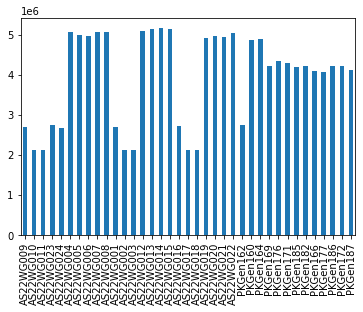

In [10]:
count_df['all_variants'].plot.bar()

In [4]:
dff = gdf.get_table()

applying filters
removing variants outside of peak interval
removed unkwon genotypes (e.g "./.")
replaced phased genotype (e.g "0|1" -> "0/1")
done
getting table


In [15]:
interval_df = pd.read_csv('data/peaks_with_overlaps1mb.csv', index_col=0)
# interval_df.CHROM = interval_df.CHROM.str.replace('chr','')
interval_df[['CHROM','FROM','TO']].to_csv('data/peak_bcftools_format.tsv', sep='\t', header=False, index=False)

In [17]:
chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr2 chr20 chr21 chr22 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chrX chrY

['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr14_GL000225v1_random',
 'chr14_KI270722v1_random',
 'chr14_KI270726v1_random',
 'chr15',
 'chr15_KI270727v1_random',
 'chr16',
 'chr16_KI270728v1_random',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr20',
 'chr21',
 'chr22',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrUn_GL000219v1',
 'chrUn_KI270752v1',
 'chrX',
 'chrY']